Calculate AUROC and AUPR ratio following LINGER study (https://github.com/Durenlab/LINGER/blob/main/docs/Benchmark.md)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [2]:
def generate_colors(N):
    color_palette = sns.color_palette("husl", N)
    colors = [mcolors.rgb2hex(color_palette[i]) for i in range(N)]
    return colors

def dot_sim(emb, gene_index, p=None):
    if not isinstance(emb, pd.DataFrame):
        raise ValueError("emb must be a pandas DataFrame")
    vector1 = emb.loc[gene_index].astype(float)
    
    sim = np.zeros(len(emb))
    
    for i in range(len(emb)):
        vector2 = emb.iloc[i].astype(float)
        
        if p is None:
            tmp = np.dot(vector1, vector2)
        else:
            norm1 = np.power(np.abs(vector1), p).sum()**(1/p)
            norm2 = np.power(np.abs(vector2), p).sum()**(1/p)
            tmp = np.dot(vector1, vector2) / (norm1 * norm2)
        sim[i] = tmp
    
    return sim


In [3]:
GT_name = '44097_RUNX1_gene_score_5fold'
Groundtruth = GT_name+'.txt'
TFName = 'RUNX1' 
file = 'naiveCD4Tcells_exp_scg_embedding.csv'


In [4]:
Infer_trans=[]

emb_file = pd.read_csv(file,index_col=0)
emb = np.tanh(emb_file)
similarities = dot_sim(emb, TFName)
similarity_df = pd.DataFrame({
    "gene": emb_file.index,
    "score": similarities
})

Infer_trans.append(similarity_df)

Method_name = "KEGNI"

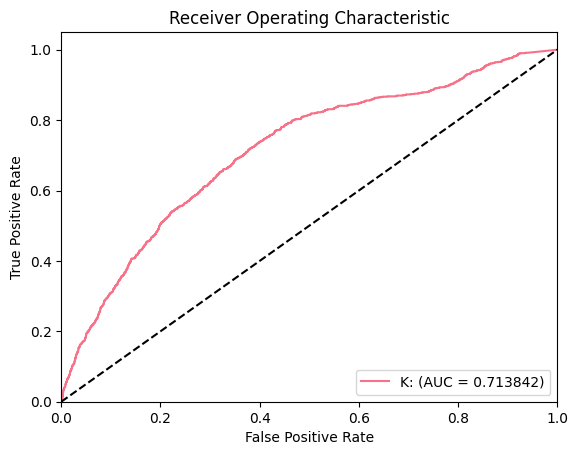

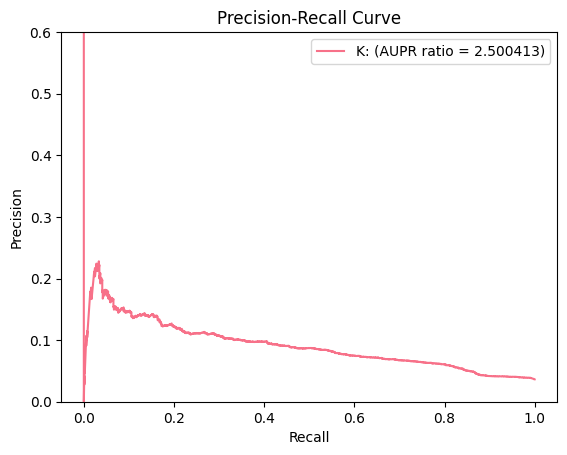

auc: 0.7138418353006445
aupr: 2.50041253660992


In [5]:
# from LingerGRN import Benchmk
import os
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
data0=pd.read_csv(Groundtruth,sep='\t', skiprows=5,header=0)
data1=data0.groupby(['symbol'])['score'].max()
label=data1.sort_values(axis=0, ascending=False)
label=label.reset_index()
N = 1000  # top 500 TG as the ground truth
label = label['symbol'].iloc[:N]
# Load data
colors=generate_colors(len(Infer_trans))
for i in range(len(Infer_trans)):

    data2 = Infer_trans[i]
    TGset=data2['gene']
    Score=data2['score'].values
    d1 = np.zeros(len(TGset))
    loc = np.where(np.isin(TGset, label))[0]   
        
        
    d1 = np.zeros(len(TGset))
    loc = np.where(np.isin(TGset, label))[0]
    d1[loc] = 1
    fpr, tpr, thresholds = roc_curve(d1, Score)
    auc = roc_auc_score(d1, Score)
    plt.plot(fpr, tpr, color=colors[i], label=Method_name[i]+': (AUC = %0.6f)' % auc)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plt.show()
plt.close()
    

for i in range(len(Infer_trans)):
    data2 = Infer_trans[i]
    TGset=data2['gene']
    Score=data2['score'].values
    d1 = np.zeros(len(TGset))
    loc = np.where(np.isin(TGset, label))[0]   
        
           
    d1 = np.zeros(len(TGset))
    loc = np.where(np.isin(TGset, label))[0]
    d1[loc] = 1
    aupr = average_precision_score(d1, Score)
    auprr=aupr*len(d1)/sum(d1)

    precision, recall, _ = precision_recall_curve(d1, Score)
    plt.plot(recall, precision, color=colors[i], label=Method_name[i]+': (AUPR ratio = %0.6f)' % auprr)
    plt.ylim([0.0, 0.6])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')
plt.show()
plt.close()

print("auc:", auc)
print("aupr:", auprr)